**Constantes**

Tamanho da sequência utilizada, tamanho da janela, frequência de _cutoff_, tamanho de lote, etc.

In [1]:
BATCH_SIZE = 32
CUTOFF_FREQUENCY = 0.009
DATA_FOLDER = '../../data'
DENSE_ACTIVATION_FUNCTION = 'linear'
EPOCHS = 200
INITIAL_LEARNING_RATE = 0.001
LSTM_COUNT = [8]
NORMALIZE = True
NOTEBOOK_NAME = '5_longest_sequence_size'
SAMPLE_RATE = 1
SEQUENCE_GAP = 25
SEQUENCE_SIZE = 50
PATINCE_EARLY_STOP = 36
PATIENCE_LR = 16
TEST_SPLIT_FACTOR = 3

In [2]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging as logging


class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                            self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):  # not new best
            if not self.in_cooldown():  # and we're not in cooldown
                if self.wait+1 >= self.patience:  # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs)  # actually reduce LR

2023-10-25 21:23:00.678294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 21:23:00.707725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 21:23:00.707749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 21:23:00.707768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 21:23:00.712870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 21:23:00.713409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Estado para reproduzir os mesmos resultados

In [3]:
from keras.utils import set_random_seed

set_random_seed(42)

# Preparação dos dados

Carregando os arquivos .csv que contém os dados de altura da lâmina e vazão.

## Altura

In [4]:
import pandas as pd

In [5]:
depth_df = pd.read_csv(f'{DATA_FOLDER}/water_depth_reservoir_Test1.csv')
display(depth_df)

,time (s),water depth (m),Unnamed: 2
0,0,0.45045,NaN
1,1,0.45070,NaN
2,2,0.45086,NaN
3,3,0.45096,NaN
4,4,0.45100,NaN
...,...,...,...
4313,4313,0.43703,NaN
4314,4314,0.43711,NaN
4315,4315,0.43720,NaN
4316,4316,0.43729,NaN


Devido à forma como o CSV está organizado, há uma coluna extra indesejada.

Para corrigir isso, podemos dropar essa coluna utilizando pandas.

In [6]:
depth_df = depth_df.drop(columns=[depth_df.columns[-1]])
display(depth_df)

,time (s),water depth (m)
0,0,0.45045
1,1,0.45070
2,2,0.45086
3,3,0.45096
4,4,0.45100
...,...,...
4313,4313,0.43703
4314,4314,0.43711
4315,4315,0.43720
4316,4316,0.43729


Ignorando coluna com o valor do tempo, pois a coluna de índice é equivalente.

In [7]:
depth_df = depth_df.drop(columns=[depth_df.columns[0]])
display(depth_df)

,water depth (m)
0,0.45045
1,0.45070
2,0.45086
3,0.45096
4,0.45100
...,...
4313,0.43703
4314,0.43711
4315,0.43720
4316,0.43729


## Vazão

In [8]:
discharge_df = pd.read_csv(f'{DATA_FOLDER}/discharge_inlet_Test1.csv')
display(discharge_df)

,time (s),inlet discharge (m3/s)
0,1,0.000630
1,1,0.000388
2,1,0.000203
3,1,0.000070
4,4,-0.000020
...,...,...
4313,4313,0.024713
4314,4314,0.024809
4315,4315,0.024889
4316,4316,0.024951


Na coluna indicando o tempo em segundos, o valor "1" está sendo repetido 4 vezes.

Tendo em vista que os valores da vazão mudaram para essas 4 entradas, vamos assumir que isso foi um erro de registro e que os valores são na realidade 0, 1, 2, ...

Essa mudança torna esse dataset consistente com o de altura carregado anteriormente.

Da mesma forma como fizemos anteriormente, podemos tratar a coluna de índices como nosso indicador de tempo.

In [9]:
discharge_df = discharge_df.drop(columns=[discharge_df.columns[0]])
display(discharge_df)

,inlet discharge (m3/s)
0,0.000630
1,0.000388
2,0.000203
3,0.000070
4,-0.000020
...,...
4313,0.024713
4314,0.024809
4315,0.024889
4316,0.024951


Podemos unir os dados em um só DF, o que facilita a preparação dos mesmos

In [10]:
unified_df = pd.concat([discharge_df, depth_df], axis=1)
display(unified_df)

,inlet discharge (m3/s),water depth (m)
0,0.000630,0.45045
1,0.000388,0.45070
2,0.000203,0.45086
3,0.000070,0.45096
4,-0.000020,0.45100
...,...,...
4313,0.024713,0.43703
4314,0.024809,0.43711
4315,0.024889,0.43720
4316,0.024951,0.43729


## Remoção de ruídos

In [11]:
from scipy.signal import butter, filtfilt

smoothed_df = unified_df.copy()

original_discharge = smoothed_df['inlet discharge (m3/s)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_discharge)
smoothed_df['inlet discharge (m3/s)'] = y

original_depth = smoothed_df['water depth (m)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_depth)
smoothed_df['water depth (m)'] = y

Verificando resultado da remoção de ruído

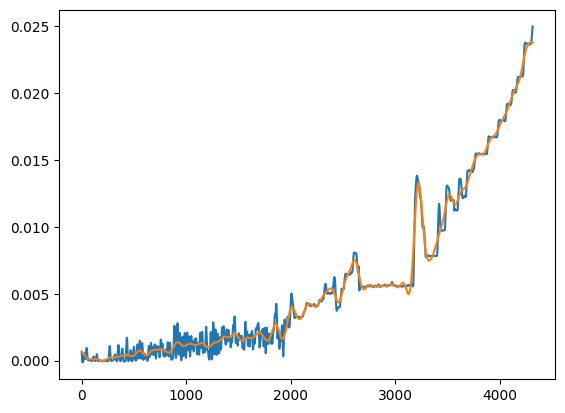

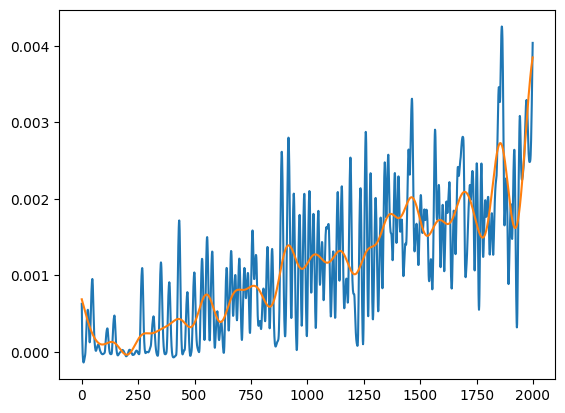

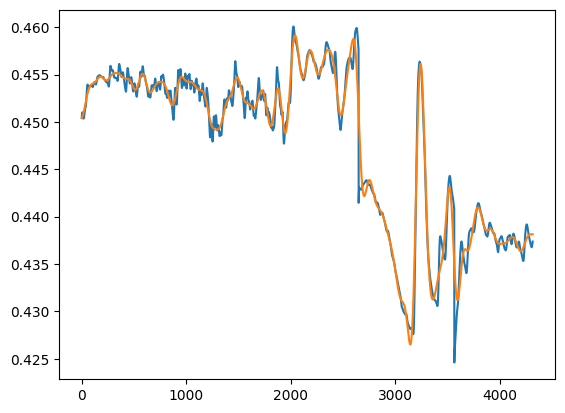

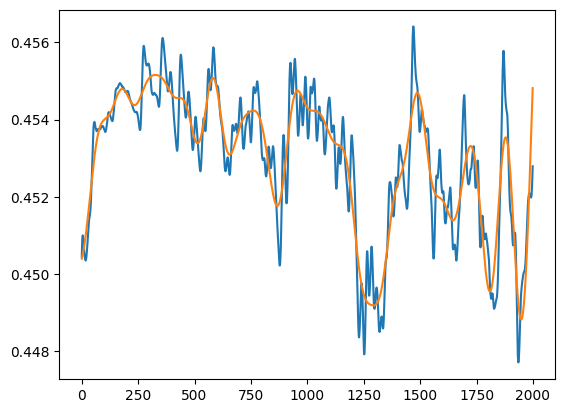

In [12]:
import matplotlib.pyplot as plt

plt.plot(unified_df['inlet discharge (m3/s)'])
plt.plot(smoothed_df['inlet discharge (m3/s)'])
plt.show()

plt.plot(unified_df['inlet discharge (m3/s)'].values[:2000])
plt.plot(smoothed_df['inlet discharge (m3/s)'].values[:2000])
plt.show()

plt.plot(unified_df['water depth (m)'])
plt.plot(smoothed_df['water depth (m)'])
plt.show()

plt.plot(unified_df['water depth (m)'].values[:2000])
plt.plot(smoothed_df['water depth (m)'].values[:2000])
plt.show()

Convertendo o DataFrame em array numpy para facilitar acesso.

In [13]:
unified = smoothed_df.to_numpy()

## Normalização

In [14]:
from sklearn.preprocessing import MinMaxScaler

unified_scaler = MinMaxScaler()
water_depth_scaler = MinMaxScaler()
inlet_discharge_scaler = MinMaxScaler()
water_depth_scaler.fit(unified[:, 1].reshape(-1, 1))
inlet_discharge_scaler.fit(unified[:, 0].reshape(-1, 1))
unified_scaler.fit(unified)

MinMaxScaler()

In [15]:
if NORMALIZE:
    unified = unified_scaler.transform(unified)

## Estrutura dos dados de treinamento

In [16]:
# Obtendo índices lower..upper
i = 0
lower = list()
upper = list()
while i + SEQUENCE_SIZE < len(unified):
    lower.append(i)
    upper.append(i + SEQUENCE_SIZE)
    print(f"[{i}, {i + SEQUENCE_SIZE})")
    i += SEQUENCE_GAP

[0, 50)
[25, 75)
[50, 100)
[75, 125)
[100, 150)
[125, 175)
[150, 200)
[175, 225)
[200, 250)
[225, 275)
[250, 300)
[275, 325)
[300, 350)
[325, 375)
[350, 400)
[375, 425)
[400, 450)
[425, 475)
[450, 500)
[475, 525)
[500, 550)
[525, 575)
[550, 600)
[575, 625)
[600, 650)
[625, 675)
[650, 700)
[675, 725)
[700, 750)
[725, 775)
[750, 800)
[775, 825)
[800, 850)
[825, 875)
[850, 900)
[875, 925)
[900, 950)
[925, 975)
[950, 1000)
[975, 1025)
[1000, 1050)
[1025, 1075)
[1050, 1100)
[1075, 1125)
[1100, 1150)
[1125, 1175)
[1150, 1200)
[1175, 1225)
[1200, 1250)
[1225, 1275)
[1250, 1300)
[1275, 1325)
[1300, 1350)
[1325, 1375)
[1350, 1400)
[1375, 1425)
[1400, 1450)
[1425, 1475)
[1450, 1500)
[1475, 1525)
[1500, 1550)
[1525, 1575)
[1550, 1600)
[1575, 1625)
[1600, 1650)
[1625, 1675)
[1650, 1700)
[1675, 1725)
[1700, 1750)
[1725, 1775)
[1750, 1800)
[1775, 1825)
[1800, 1850)
[1825, 1875)
[1850, 1900)
[1875, 1925)
[1900, 1950)
[1925, 1975)
[1950, 2000)
[1975, 2025)
[2000, 2050)
[2025, 2075)
[2050, 2100)
[2075,

Construindo sequência de inputs e outputs utilizadas pela rede.

No caso desse notebook:

- Input: Vazão
- Output: Vazão

In [17]:
import numpy as np

number_of_sequences = len(lower)
display("Quantidade de sequências", number_of_sequences)

TRAINING_SIZE = int(number_of_sequences * (1 - 1 / TEST_SPLIT_FACTOR))
display("Quantidade de sequências de treinamento", TRAINING_SIZE)

inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
outputs = np.zeros((number_of_sequences, 1))
for i in range(number_of_sequences):
    inputs[i, :] = unified[lower[i]:upper[i], 0].reshape(-1, 1)
    outputs[i, :] = unified[upper[i], 0]

inputs_train = inputs[:TRAINING_SIZE]
outputs_train = outputs[:TRAINING_SIZE]
inputs_test = inputs[TRAINING_SIZE:]
outputs_test = outputs[TRAINING_SIZE:]
display("Shapes", inputs_train.shape, outputs_train.shape,
        inputs_test.shape, outputs_test.shape)

'Quantidade de sequências'

171

'Quantidade de sequências de treinamento'

114

'Shapes'

(114, 50, 1)

(114, 1)

(57, 50, 1)

(57, 1)

# Rede neural e treinamento (Adam)

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
import os

if os.path.exists(f'{NOTEBOOK_NAME}/model.png'):
    os.remove(f'{NOTEBOOK_NAME}/model.png')

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = Adam(learning_rate=INITIAL_LEARNING_RATE, amsgrad=True)

if not os.path.exists(NOTEBOOK_NAME):
    os.mkdir(NOTEBOOK_NAME)
plot_model(model, f'{NOTEBOOK_NAME}/model.png', show_shapes=True)
model.compile(loss='mae', optimizer=opt)

2023-10-25 21:23:03.515730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 21:23:03.516457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "5_longest_sequence_size"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, 8)                 320       
                                                                 
 linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATINCE_EARLY_STOP,
                      verbose=1, restore_best_weights=True, start_from_epoch=66),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_adam.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_adam.h5',
                          monitor='val_loss', patience=PATIENCE_LR, factor=0.5, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_adam.h5')

Epoch 1/200
3/3 [==============================] - 2s 207ms/step - loss: 0.0407 - val_loss: 0.1329 - lr: 0.0010
Epoch 2/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0290 - val_loss: 0.1101 - lr: 0.0010
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0239 - val_loss: 0.0893 - lr: 0.0010
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0233 - val_loss: 0.0753 - lr: 0.0010
Epoch 5/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0237 - val_loss: 0.0702 - lr: 0.0010
Epoch 6/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0217 - val_loss: 0.0694 - lr: 0.0010
Epoch 7/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0186 - val_loss: 0.0720 - lr: 0.0010
Epoch 8/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0169 - val_loss: 0.0721 - lr: 0.0010
Epoch 9/200
3/3 [==============================] - 0s 17ms/step - loss: 0.0160 - val_loss: 0.0664 - lr: 0.0010


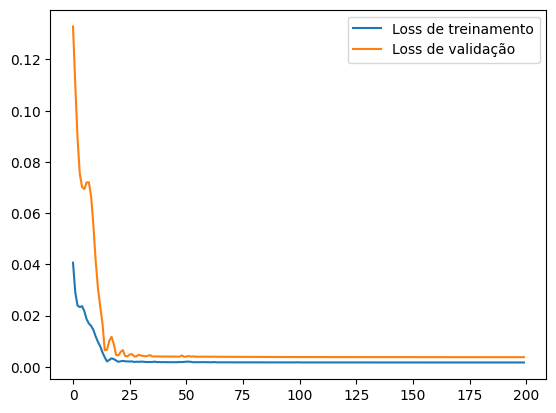

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.savefig(f'{NOTEBOOK_NAME}/loss_adam.png')

## Resultados obtidos

Comparando predições para as sequências separadas para teste

Dados de treinamento: primeiro a rede precisa ser capaz de apresentar um desempenho satisfatório para os dados que foram utilizados em seu treinamento...

4/4 [==============================] - 0s 2ms/step


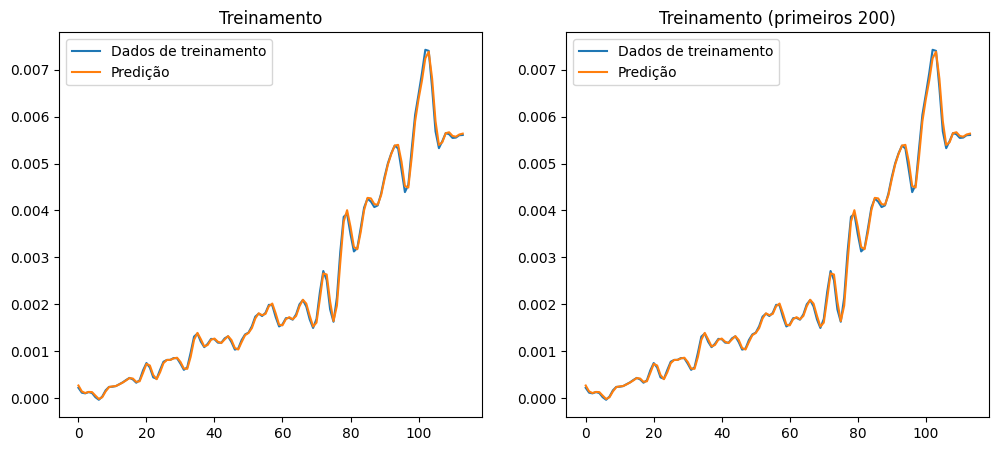

In [21]:
predictions = model.predict(inputs_train)
if NORMALIZE:
    predictions = inlet_discharge_scaler.inverse_transform(predictions)
    temp = inlet_discharge_scaler.inverse_transform(outputs_train)
else:
    temp = outputs_train

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(temp, label='Dados de treinamento')
ax[0].plot(predictions, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

# zoom

ax[1].plot(temp[:200], label='Dados de treinamento')
ax[1].plot(predictions[:200], label='Predição')
ax[1].legend()
ax[1].set_title('Treinamento (primeiros 200)')
plt.savefig(f'{NOTEBOOK_NAME}/train_adam.png')

Dados de teste: agora é a hora da verdade.

2/2 [==============================] - 0s 3ms/step


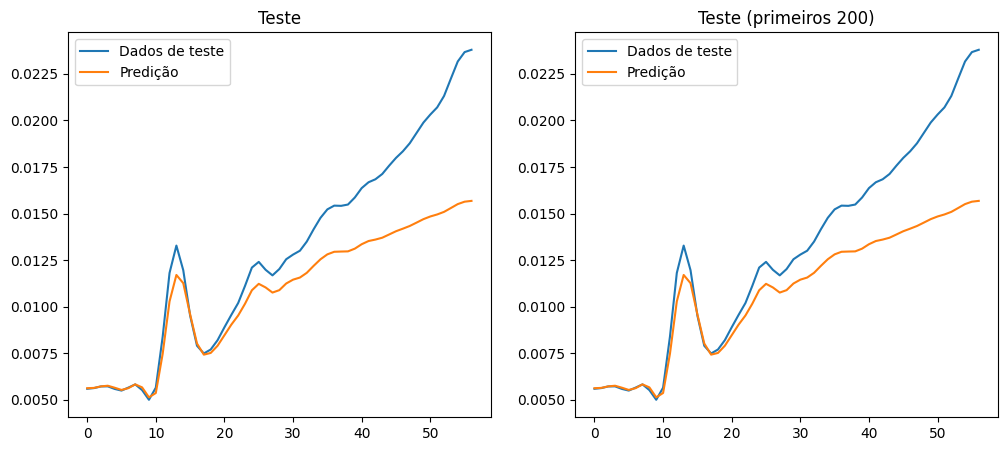

In [22]:
predictions = model.predict(inputs_test)
if NORMALIZE:
    predictions = inlet_discharge_scaler.inverse_transform(predictions)
    temp = inlet_discharge_scaler.inverse_transform(outputs_test)
else:
    temp = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(temp, label='Dados de teste')
ax[0].plot(predictions, label='Predição')
ax[0].legend()
ax[0].set_title('Teste')

# zoom

ax[1].plot(temp[:200], label='Dados de teste')
ax[1].plot(predictions[:200], label='Predição')
ax[1].legend()
ax[1].set_title('Teste (primeiros 200)')
plt.savefig(f'{NOTEBOOK_NAME}/test_adam.png')

# Rede neural e treinamento (SGD)

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import SGD

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = SGD(learning_rate=INITIAL_LEARNING_RATE, momentum=0.9)
model.compile(loss='mae', optimizer=opt)

Model: "5_longest_sequence_size"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, 8)                 320       
                                                                 
 linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATINCE_EARLY_STOP,
                      verbose=1, restore_best_weights=True, start_from_epoch=66),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_sgd.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_sgd.h5',
                          monitor='val_loss', patience=PATIENCE_LR, factor=0.5, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_sgd.h5')

Epoch 1/200
3/3 [==============================] - 1s 168ms/step - loss: 0.0327 - val_loss: 0.1047 - lr: 0.0010
Epoch 2/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0233 - val_loss: 0.0843 - lr: 0.0010
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0238 - val_loss: 0.0726 - lr: 0.0010
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0259 - val_loss: 0.0760 - lr: 0.0010
Epoch 5/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0229 - val_loss: 0.0882 - lr: 0.0010
Epoch 6/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0208 - val_loss: 0.0945 - lr: 0.0010
Epoch 7/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0219 - val_loss: 0.0931 - lr: 0.0010
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0210 - val_loss: 0.0856 - lr: 0.0010
Epoch 9/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0204 - val_loss: 0.0804 - lr: 0.0010


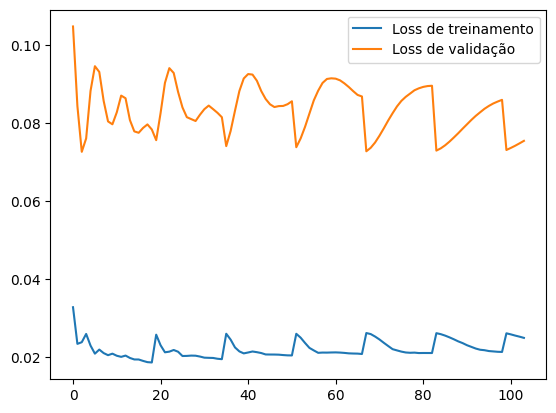

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.savefig(f'{NOTEBOOK_NAME}/loss_sgd.png')

## Resultados obtidos

Comparando predições para as sequências separadas para teste

Dados de treinamento: primeiro a rede precisa ser capaz de apresentar um desempenho satisfatório para os dados que foram utilizados em seu treinamento...

4/4 [==============================] - 0s 2ms/step


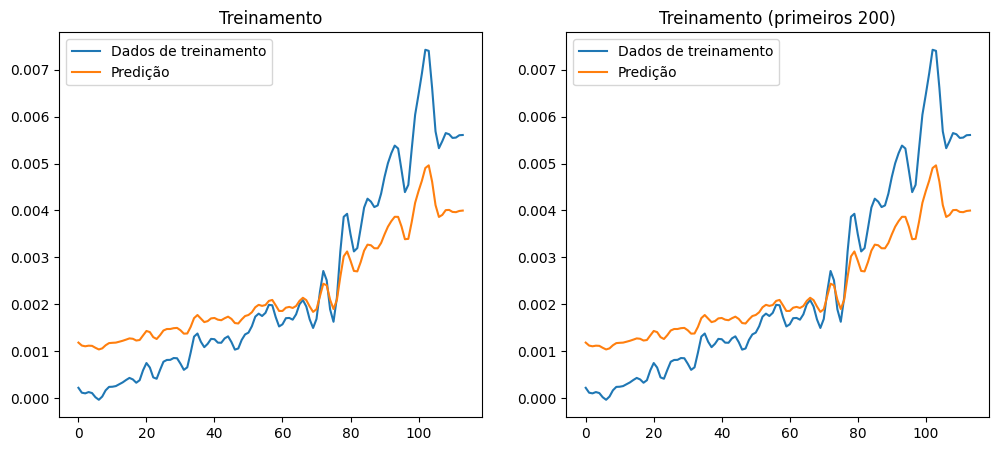

In [26]:
predictions = model.predict(inputs_train)
if NORMALIZE:
    predictions = inlet_discharge_scaler.inverse_transform(predictions)
    temp = inlet_discharge_scaler.inverse_transform(outputs_train)
else:
    temp = outputs_train

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(temp, label='Dados de treinamento')
ax[0].plot(predictions, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

# zoom

ax[1].plot(temp[:200], label='Dados de treinamento')
ax[1].plot(predictions[:200], label='Predição')
ax[1].legend()
ax[1].set_title('Treinamento (primeiros 200)')
plt.savefig(f'{NOTEBOOK_NAME}/train_sgd.png')

Dados de teste: agora é a hora da verdade.

2/2 [==============================] - 0s 3ms/step


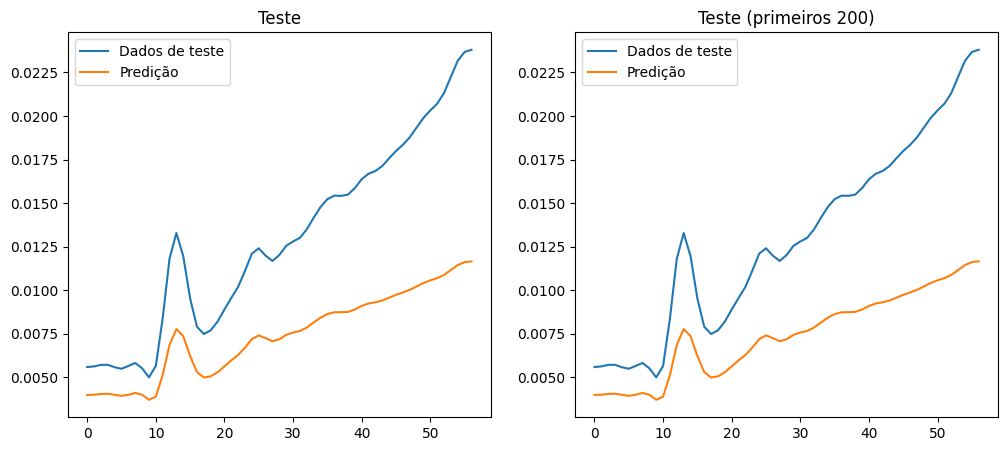

In [27]:
predictions = model.predict(inputs_test)
if NORMALIZE:
    predictions = inlet_discharge_scaler.inverse_transform(predictions)
    temp = inlet_discharge_scaler.inverse_transform(outputs_test)
else:
    temp = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(temp, label='Dados de teste')
ax[0].plot(predictions, label='Predição')
ax[0].legend()
ax[0].set_title('Teste')

# zoom

ax[1].plot(temp[:200], label='Dados de teste')
ax[1].plot(predictions[:200], label='Predição')
ax[1].legend()
ax[1].set_title('Teste (primeiros 200)')
plt.savefig(f'{NOTEBOOK_NAME}/test_sgd.png')